In [1]:
import os
import torch
import pickle
import random
import numpy as np
import scanpy as sc

import NEXUS 
from NEXUS.sample_emb.Graph_model import GraphVAE
from NEXUS.model_int.GNNExplainer_GNN.GNN_explainer import GraphEncoderWrapper, GNNexplainer_nexus, aggregate_graph_importance, extract_feature_importance, GNNexplainer_hotplot

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
input_path = "./../test_data/2_graph_emb_output/"
input_adata_path = input_path+'graph_embedded_adata.h5ad'
input_graph_dataset_path = input_path+"Graph_embedded.pickle"
input_model_param_path = input_path+"Graph_VAE_model.pt"
output_path = "./../test_data/4_GNNExplainer_output/"
label = "sample_cluster"

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
adata = sc.read_h5ad(input_adata_path)
with open(input_graph_dataset_path, 'rb') as file:
    graph_dataset = pickle.load(file)
graph_dataset = sorted(graph_dataset, key=lambda data: data.sample)

In [5]:
pooling_type = 'mean'
input_dim = 64
hidden_dim = 64
latent_dim = 32
heads = 2
edge_dims = 1
class_num = len(np.unique(adata.obs['cluster']))

In [6]:
model = GraphVAE(input_dim, hidden_dim, latent_dim, class_num, pooling_type = pooling_type, heads = heads, edge_dims = edge_dims)
checkpoint = torch.load(input_model_param_path, map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint.state_dict())
Graph_encoder = model.encoder

In [7]:
GNNexplainer_nexus(adata, Graph_encoder, graph_dataset, epochs=10, save_path = output_path+"node_masks.pkl")

All node_mask have been saved to : ./../test_data/4_GNNExplainer_output/node_masks.pkl


{'0': array([[0.47037598, 0.47820723, 0.51539475, ..., 0.47679076, 0.4715813 ,
         0.48961312],
        [0.4697749 , 0.46674094, 0.4520927 , ..., 0.46375626, 0.5038285 ,
         0.45444188],
        [0.5338834 , 0.5333199 , 0.45573756, ..., 0.44270593, 0.48625767,
         0.44453564],
        ...,
        [0.5136948 , 0.5346626 , 0.49937066, ..., 0.4668868 , 0.52475905,
         0.48518348],
        [0.48862827, 0.50019634, 0.470346  , ..., 0.46627146, 0.4603022 ,
         0.48355648],
        [0.4821029 , 0.5014317 , 0.45085558, ..., 0.47055206, 0.49930415,
         0.48461735]], dtype=float32),
 '1': array([[0.4642003 , 0.48967233, 0.47643986, ..., 0.42961827, 0.5413065 ,
         0.4754162 ],
        [0.48666102, 0.51523936, 0.45980102, ..., 0.48569936, 0.46964252,
         0.4664813 ],
        [0.49479097, 0.47160417, 0.4922995 , ..., 0.4830773 , 0.47671637,
         0.43371144],
        ...,
        [0.52511936, 0.49971056, 0.48815545, ..., 0.49770603, 0.48869225,
         

In [8]:
input_path = "./../test_data/2_graph_emb_output/"

In [9]:
with open(input_path+"Graph_embedded.pickle", 'rb') as f:
    graph_dataset = pickle.load(f)
graph_dataset = sorted(graph_dataset, key=lambda data: data.sample)
adata_cell = sc.read_h5ad(input_path+"cell_embedded_adata.h5ad")
adata = sc.read_h5ad(input_path+'graph_embedded_adata.h5ad')
with open("./../test_data/4_GNNExplainer_output/node_masks.pkl", 'rb') as f:
    node_masks = pickle.load(f)

F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
importance_dict = aggregate_graph_importance(node_masks, aggregation='sum')
feature_importance = extract_feature_importance(importance_dict)

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# transpose -> scale rows -> transpose back
feature_importance_scaled = pd.DataFrame(
    scaler.fit_transform(feature_importance.T).T,
    index=feature_importance.index,
    columns=feature_importance.columns
)

In [12]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='cluster',
    method='wilcoxon',
    n_genes=200,
    key_added='rank_genes'
)

F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


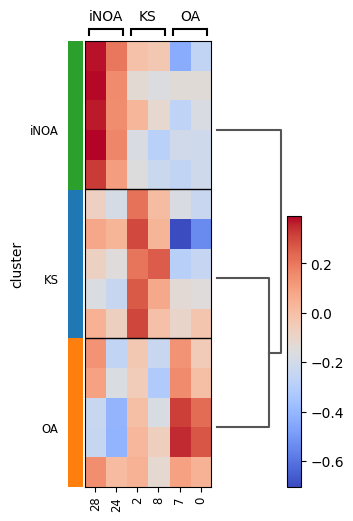

In [13]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    key="rank_genes",
    n_genes=2,
    groupby="cluster",
    show_gene_labels=True,
    cmap="coolwarm",
    save="feature_importance.pdf"
)